In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Enable memory growth for the GPU
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[-1], enable=True)

# Introduction

In this and the next DataLabs you will build and train the following Multilayer perceptron (MLP) for binary classification:

<img src=https://i.imgur.com/fmkZQQr.png width="800">
<strong>Figure 1: The MLP architecture you will build this week.</strong>


This network consists of
- one input layer with 2 units
- one hidden layer with 3 units
- one output layer with 1 unit.
- 9 weights (arrows).

We can represent this architecture succintly as a list of layers where each layer is an integer representing the number of units:

In [4]:
nn_architecture = [2, 3, 1]

We will refer to these layers by a `layer_id`. Since Python is 0-indexed, input layer will be layer 0, hidden layer will be layer 1 and the output layer will be layer 2. Then we can easily access the number of units in a layer, for example layer 1, using `layer_id` as follows:

In [5]:
layer_id = 1
units = nn_architecture[layer_id]
print(f'There are {units} units in layer {layer_id}.')

There are 3 units in layer 1.


Similarly for the units, their ids will start from `0`.

<img src=https://i.imgur.com/8tRkE1R.png width="800">
<strong>Figure 2: The MLP with layer and unit IDs.</strong>


# The Dataset

A binary classification dataset is created for you to use.

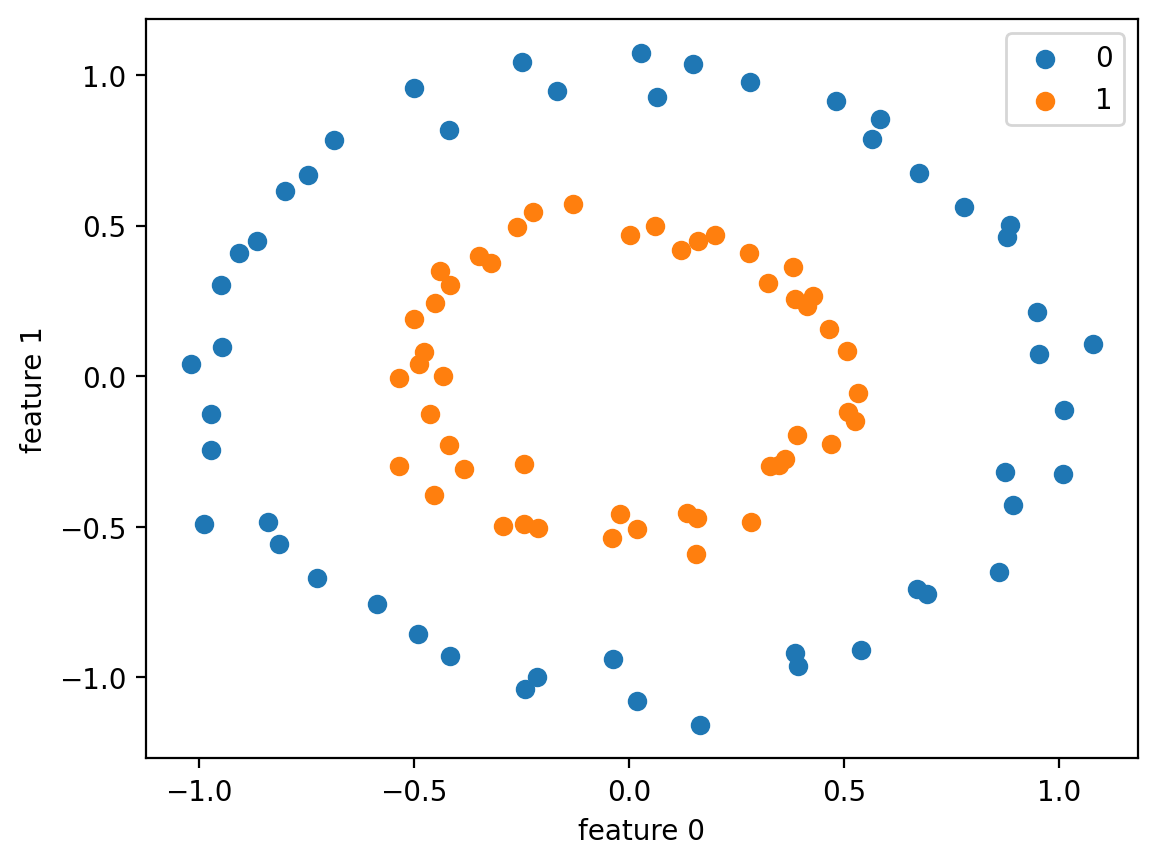

In [6]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=100, noise=0.05, factor=0.5, random_state=0)
plt.figure(dpi=200)
plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0], label=0)
plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1], label=1)
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.legend()

In [7]:
y = y.reshape(-1, 1)
X.shape, y.shape

((100, 2), (100, 1))

# Outline

Here is an outline of the tasks you need to achieve to implement an MLP from scratch.

**DataLab 1**

**Task 1**: Given an MLP architecture (e.g. `[2, 3, 1]`), define a function that returns random weights and biases around zero.

**Task 2**: Implement the sigmoid activation function.

**Task 3**: Implement the predict function.

**Task 4**: Define a function that calculates accuracy.

**Task 5**: Define a function that calculates mean square error (loss).

**DataLab 2**

**Task 6**: Define a function that implements a naive gradient descent algorithm.

# Keras

The idea is to implement an MLP without Keras. But we can still use Keras to get an overview.

For example, in Keras, this is how you define an MLP with `nn_architecture = [2, 3, 1]` and sigmoid activations.

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(3, input_shape=(2,), activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3)                 9         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


It has 13 weights & biases (related to Task 1).

In [9]:
# Notice that this returns weights and biases, not just weights
model.get_weights()

[array([[-0.4529066 ,  0.9668617 , -0.08290386],
        [ 0.6583185 , -1.05177   , -0.46658587]], dtype=float32),
 array([0., 0., 0.], dtype=float32),
 array([[-0.21182168],
        [ 0.710639  ],
        [-1.0850801 ]], dtype=float32),
 array([0.], dtype=float32)]

The `model` has a `predict` method that can calculate an output by multiplying an input with weights, adding bias and applying an activation function (related to Tasks 2&3).

In [10]:
output = model.predict([[-1.5, 2]])
output

array([[0.37728828]], dtype=float32)

<img src=https://i.imgur.com/zgLpuCX.png width="800">
<strong>Figure 3: Predict method on an example datapoint.</strong>


Weights and biases are random therefore we have an untrained MLP. Next steps are to define a loss function (Task 5) and an optimizer (Task 6) to minimize this loss. Metrics are calculated so that we can understand how well the model is doing (Task 4).

In [11]:
model.compile(loss='mse', optimizer='sgd', metrics=['accuracy'])
model.fit(X, y)

4/4 [==============================] - 0s 1ms/step - loss: 0.2565 - accuracy: 0.5000


# Task 1: Build an MLP

Now, to create and operate weigths and biases, it is useful to have a notation to refer to each weight and bias. As mentioned previously, the arrows on the MLP diagram represent the weights. We can also add a bias unit to represent biases.

<img src=https://i.imgur.com/GrVOa6w.png width="500">
<strong>Figure 4: Notation for weights, biases and unit values in an MLP.</strong>


Each weight is represented as $w^{(l)}_{ij}$ where

$l$: weights connecting layer $l$ to layer $l+1$

$i$: $i^{th}$ unit in layer $l$

$j$: $j^{th}$ unit in layer $l+1$

According to this definition, weights connecting layer 0 to layer 1 can be written as:

$w^{(0)}=\begin{pmatrix}
w^{(0)}_{00} & w^{(0)}_{01} & w^{(0)}_{02}\\
w^{(0)}_{10} & w^{(0)}_{11} & w^{(0)}_{12}
\end{pmatrix}$

In [12]:
w0 = np.random.randn(2, 3)
w0

array([[ 0.6835114 , -2.08960057, -0.0776903 ],
       [ 1.94239442, -0.83268137, -1.21369127]])

Similarly, remaining weights and biases are:

$w^{(1)}=\begin{pmatrix}
w^{(1)}_{00}\\
w^{(1)}_{10}\\
w^{(1)}_{20}\\
\end{pmatrix}$

$b^{(0)}=\begin{pmatrix}
b^{(0)}_{0}, b^{(0)}_{1}, b^{(0)}_{2}\\
\end{pmatrix}$


$b^{(1)}=\begin{pmatrix}
b^{(1)}_{0}\\
\end{pmatrix}$

Notice that the shape of a weight matrix ($w^{(l)}$) is (number of units in layer $l$, number of units in layer $l+1$).

In [13]:
w0.shape

(2, 3)

And, the shape of a bias matrix ($b^{(l)}$) is (1, number of units in layer $l+1$)

Understanding this is crucial for
- initializing weights and biases
- implementing a forward-pass (the predict function)
- accessing individual weights and biases
- updating weights and biases

For example, if we have a list of all weights called `weights`:

In [14]:
w1 = np.random.randn(3, 1)
weights = [w0, w1]
weights

[array([[ 0.6835114 , -2.08960057, -0.0776903 ],
        [ 1.94239442, -0.83268137, -1.21369127]]),
 array([[-0.92363904],
        [-0.04938962],
        [-0.97868184]])]

We can access $w^{(1)}_{20}$ as

In [15]:
weights[1][2, 0]

-0.9786818416901754

Try it yourself, can you print out the value of $w^{(0)}_{12}$?

In [16]:
weights[0][1, 2]

-1.2136912719853312

Now you are ready to define the initializer. Use `np.random.randn()` to initialize weights and biases from the standard normal distribution.

We can represent all the parameters of the model with two lists. `weights` is a list containing $w^{(l)}$ arrays and `biases` is a list containing $b^{(l)}$ arrays.

For example in our case the model `nn_architecture = [2, 3, 1]` will have the following parameters:

`weights = [w0, w1]` and `biases = [b0, b1]`

you have seen each array previously. Here are the arrays again:

$w^{(0)}=\begin{pmatrix}
w^{(0)}_{00} & w^{(0)}_{01} & w^{(0)}_{02}\\
w^{(0)}_{10} & w^{(0)}_{11} & w^{(0)}_{12}
\end{pmatrix}$

$w^{(1)}=\begin{pmatrix}
w^{(1)}_{00}\\
w^{(1)}_{10}\\
w^{(1)}_{20}\\
\end{pmatrix}$

$b^{(0)}=\begin{pmatrix}
b^{(0)}_{0}, b^{(0)}_{1}, b^{(0)}_{2}\\
\end{pmatrix}$


$b^{(1)}=\begin{pmatrix}
b^{(1)}_{0}\\
\end{pmatrix}$

Define the `initializer()` such that it returns `weights` and `biases` for any given `nn_architecture`.

In [17]:
# Task 1
def initializer(nn_architecture):
    '''
    Given
    - the number of layers 
    - the number of units in each layer
    initializes network parameters (weights and biases)
    
    Arguments
        nn_architecture: a list of integers
                         length of the list is the number of layers
                         each item in the list specifies 
                         the number of units in that layer
    Returns
        weights: list of numpy arrays, w0, w1...
        biases: list of numpy arrays, b0, b1...
        
    '''
    weights = []
    biases = []
    
    for l in range(1, len(nn_architecture)):
        w = np.random.randn(nn_architecture[l-1], nn_architecture[l])
        b = np.random.randn(1, nn_architecture[l])
        weights.append(w)
        biases.append(b)
    
    return weights, biases

If you implemented the function correctly, `nn_architecture=[2, 3, 1]` should return weights and biases with shapes:

- `weights[0].shape == (2, 3)`
- `weights[1].shape == (3, 1)`
- `biases[0].shape == (1, 3)`
- `biases[1].shape == (1, 1)`

In [18]:
weights, biases = initializer([2, 3, 1])

In [19]:
print(weights[0].shape)
print(weights[1].shape)
print(biases[0].shape)
print(biases[1].shape)

(2, 3)
(3, 1)
(1, 3)
(1, 1)


## Task 2: The sigmoid activation

Implement the sigmoid activation function:

$sigmoid(x) = 1/(1+e^{-x})$

In [20]:
# Task 2
def sigmoid(x):
    '''
    Calculates the sigmoid of an input
    Arguments
        x: np.array() of real numbers
    Returns
        np.array() of real numbers between 0 and 1
    
    '''
    x = 1/(1+np.exp(-x))
    
    return x

If you implemented the function correctly, the code below should plot the following:

<img src=https://i.imgur.com/Ad0WSTL.png width="500">
<strong>Figure 5: The sigmoid function.</strong>

Text(0, 0.5, '$1/(1+e^{-x})$')

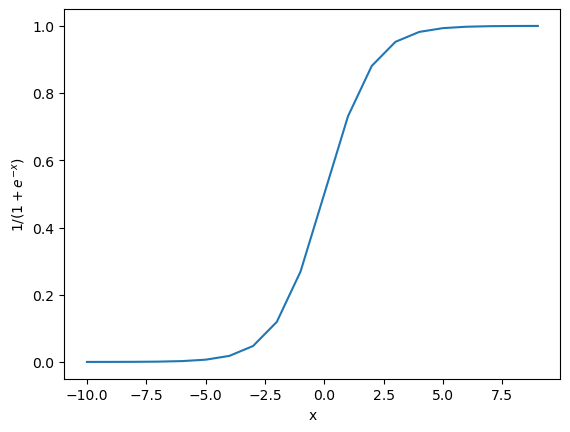

In [21]:
plt.plot(np.arange(-10, 10), sigmoid(np.arange(-10, 10)))
plt.xlabel('x')
plt.ylabel('$1/(1+e^{-x})$')

## Task 3: Predict

If you check the Keras documentation for the `Dense` layer it says:

> `Dense` implements the operation: `output = activation(dot(input, kernel) + bias)` where `activation` is the element-wise activation function passed as the `activation` argument, `kernel` is a weights matrix created by the layer, and `bias` is a bias vector created by the layer. These are all attributes of Dense.

Let's look back to the MLP notation and understand how we can calculate the output unit ($a^{(2)}_{0}$) from input units ($x_0$ and $x_1$). This is what `predict` method is all about.

<img src=https://i.imgur.com/GrVOa6w.png width="500">
<strong>Figure 6: How to calculate $a^{(2)}_{0}$ from $x_0$ and $x_1$?</strong>

First we need to calculate Layer 1 unit values from Layer 0. Then we can calculate the output unit from Layer 1 unit values.


Layer 1 unit values:

$a^{(1)}_{0} = sigmoid(x_0 * w^{(0)}_{00} + x_1 * w^{(0)}_{10} + 1 * b^{(0)}_{0})$

$a^{(1)}_{1} = sigmoid(x_0 * w^{(0)}_{01} + x_1 * w^{(0)}_{11} + 1 * b^{(0)}_{1})$

$a^{(1)}_{2} = sigmoid(x_0 * w^{(0)}_{02} + x_1 * w^{(0)}_{12} + 1 * b^{(0)}_{2})$

Layer 2 unit value (the output):

$a^{(2)}_{0} = sigmoid(a^{(1)}_{0} * w^{(1)}_{00} + a^{(1)}_{1} * w^{(1)}_{10} + a^{(1)}_{2} * w^{(1)}_{20} + 1 * b^{(1)}_{0})$

That's it! You can write for loops to implement these operations. But it will be much more efficient to use linear algebra and vectorization.

Layer 1:

$a^{(1)} = sigmoid(x\cdot w^{(0)} + b^{(0)})$

where

$a^{(1)}=\begin{pmatrix}
a^{(1)}_{0} & a^{(1)}_{1} & a^{(1)}_{2}
\end{pmatrix}$

$x=\begin{pmatrix}
x_{0} & x_{1}
\end{pmatrix}$

$w^{(0)}=\begin{pmatrix}
w^{(0)}_{00} & w^{(0)}_{01} & w^{(0)}_{02}\\
w^{(0)}_{10} & w^{(0)}_{11} & w^{(0)}_{12}
\end{pmatrix}$

$b^{(0)}=\begin{pmatrix}
b^{(0)}_{0} & b^{(0)}_{1} & b^{(0)}_{2}
\end{pmatrix}$

Now compare this equation with the Keras documentation:

$a^{(1)} = sigmoid(x\cdot w^{(0)} + b^{(0)})$

`output = activation(dot(input, kernel) + bias)`



Similarly for Layer 2:

$a^{(2)} = sigmoid(a^{(1)}\cdot w^{(1)} + b^{(1)})$

Define the `predict()` function below that calculates the output of an ML, given the input (X) and the parameters (weights, biases) of the MLP.

In [22]:
# Task 3
def predict(X, weights, biases):
    '''
    Given an input and NN parameters,
    this function calculates the output
    
    Arguments
        X: np.array() of shape 
        (#datapoints, #features)
        weights: list of np arrays
        biases: list of np arrays
    Returns
        y_pred: np.array() of shape
        (#datapoints, #classes)
    
    '''
    
    y_pred = X
    for w, b in zip(weights, biases):
        y_pred = sigmoid(y_pred @ w + b)
    
    return y_pred

If you implemented the function correctly, `y_pred.shape` should be `(#datapoints, #classes)` which is `(100, 1)` in our case.

In [23]:
y_pred = predict(X, weights, biases)

If the function is implemented correctly, the code below should plot something similar to figure 7. x-axis shows each datapoint by id and y-axis shows its value. Blue dots are the labels (0 or 1) and orange dots are the predictions (between 0 and 1). Blue and orange dots corresponding to the same datapoint are connected by a red line which represents the error. Shorter the red lines, better the predictions.

In your case, the predictions can be different due to random initialization. But the error must still be high.

<img src=https://i.imgur.com/CqT0E0i.png width="600">
<strong>Figure 7: Predictions from an untrained MLP.</strong>


Notice that the predictions are:
- between 0 and 1, due to sigmoid activation function
- random, i.e. accuracy is ~50% because the networks is not yet trained
- not binary, i.e. if you want to calculate accuracy you need to convert these to binary using a discrimination threshold such as 0.5

Text(0, 0.5, 'Output')

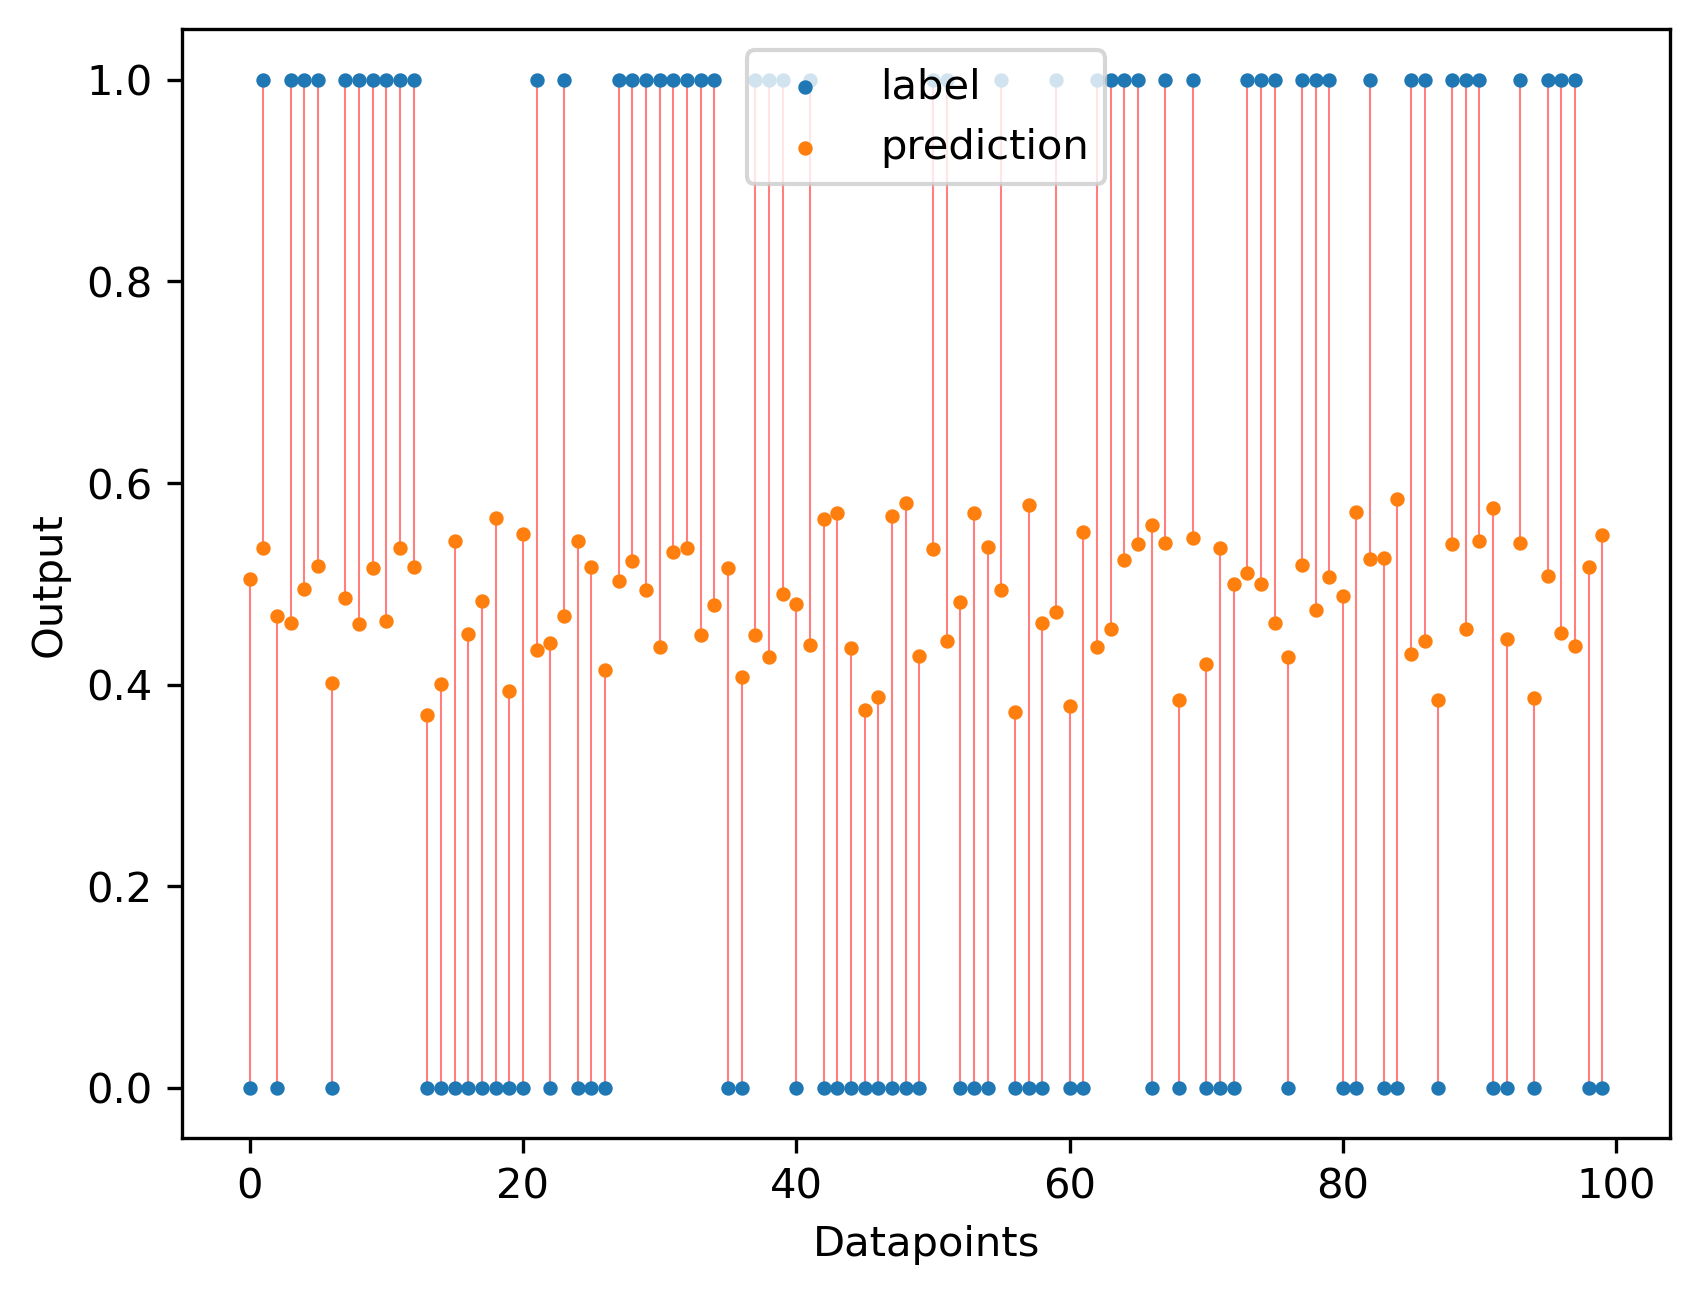

In [24]:
plt.figure(dpi=300)

for i in range(0, y.shape[0]):
    plt.plot([i, i], [y[i], y_pred[i]], color='red', zorder=-10, alpha=0.5, linewidth=0.5)

plt.scatter(np.arange(0, y.shape[0]), y, label='label', s=6)
plt.scatter(np.arange(0, y_pred.shape[0]), y_pred, label='prediction', s=6)

plt.legend()
plt.xlabel('Datapoints')
plt.ylabel('Output')

## Task 4: Calculate Accuracy

Convert predictions to binary and calculate accuracy. If implemented correctly, accuracy of an untrained network should be around 0.5.

In [25]:
# convert to binary
y_pred_binary = 1*(y_pred > 0.5)

In [26]:
# Task 4
def accuracy(y_pred_binary, y):
    '''
    Given 
    -binary predictions
    -labels
    calculates accuracy
    
    '''
    y_true = 1, 0
    accuracy = np.mean(y_pred_binary == y_true)
    
    return accuracy

In [27]:
accuracy(y_pred_binary, y)

0.5

## Task 5: Loss function

The loss function measures the difference between the predictions and the labels. Gradients descent minimizes this loss. Therefore we need to define a loss function to train an MLP.

There are tens of loss functions. You can check the Keras documentation to see the available options (https://keras.io/api/losses/). Your task is to implement mean squared error (MSE).

$MSE = mean(square(y - y\_pred))$



In [28]:
# Task 5
def loss_function(X, y, weights, biases):
    '''
    Given
    - X, y, weights, biases
    
    calculates the mean squared error (mse)
    '''
    y_pred = predict(X, weights, biases)
    loss = np.mean(np.square(y-y_pred))
    return loss

In [29]:
loss_function(X, y, weights, biases)

0.2500511543623891

## Task 6: Gradient Descent (Friday)

Your final task is to implement a naive version of the gradient descent (GD) algorithm. This is part of Friday's datalab. 

GD is the essence of neural networks because this is what is meant by **learning**.

When we initialize a network we have random weights and biases (Task 1). We would like to update the parameters such that the loss decreases. Loss is the difference between predictions and labels. Decreasing loss means improving predictions, sometimes called learning or training.

- Calculate the loss using `loss_function(X, y, weights, biases)`
- Update weights slightly to reduce loss
- Repeat n times, where n is called the number of epochs

The GD update rule is:

`updated_weigths = current_weights - learning_rate * gradient of the loss function`

`updated_biases = current_biases - learning_rate * gradient of the loss function`

**What is the gradient and how to calculate it?**

In our case gradient is the direction and rate of fastest increase of the loss function ($L$). Nabla symbol represents the gradient operation. We can use the following notation to represent the gradient of the loss function:

$\nabla L$

We would like to decrease the loss. To achieve this we go in the opposite direction ($-\nabla L$) using a step size called learning rate ($lr$). Therefore to we add $-lr*\nabla L$ to the parameter to update it.

Gradient is defined as the partial derivates of loss with respect to each weight ($\frac{\partial L}{\partial w}$) and bias ($\frac{\partial L}{\partial b}$). Therefore the GD update rule for each weight and bias is defined as:

$w_{updated} = w - lr * \frac{\partial L}{\partial w}$

$b_{updated} = b - lr * \frac{\partial L}{\partial b}$

Now, if we can calculate the partial derivatives, we are done! Gradient is typically calculated using backpropogation, but it is out of the scope of this DataLab. Therefore we will use a simpler method to estimate the partial derivates.

Let's understand this by estimating partial derivate of a single parameter $\frac{\partial L}{\partial w^{(0)}_{00}}$

1. Assume the initial value of the parameter $w^{(0)}_{00}$ is 0.3.
2. Calculate the loss using `loss_function(X, y, weights, biases)`
3. Let's say it is 0.5
4. Add a very small number to $w^{(0)}_{00}$. Small numbers are typically represented by epsilon. Let's assume `epsilon=1e-4`. $w^{(0)}_{00}+10^{-4}$
5. Freeze all weights and biases, only change $w^{(0)}_{00}$ to $w^{(0)}_{00}+10^{-4}$.
6. Calculate the loss again (Say it is 0.51)
7. You can estimate $\frac{\partial L}{\partial w^{(0)}_{00}}$ as $\frac{0.51-0.5}{10^{-4}}$. In other words, change in loss divided by change in the parameter.
8. Then we can use the update rule to calculate the new value of weight as: $w^{(0)}_{00} = 0.3 - lr*\frac{0.51-0.5}{10^{-4}}$
9. Repeat this for all weights and biases. This will give you one epoch of gradient descent.
10. Repeat this for a certain number of epochs.

It is easier implement this algorithm by breaking it into subtasks.

**Task 6.1**: Define a function to update a single weight given all weigths of an MLP (Step 5).

**Task 6.2**: Define a function to update a single bias given all biases of an MLP (Step 5).

**Task 6.3**: Now it is time to estimate the partial derivatives. Define a function that can add a small number (epsilon) to a weight (Steps 4&5) and calculates the change in loss (Step 7). Do this for all weights and biases.

**Task 6.4**: Implement one-step gradient descent (Steps 8&9).

**Task 6.5**: The rest is easy, simply repeat one-step gradient descent for a given number of epochs.

### Task 6.1

In [30]:
# Task 6.1
def w_update(weights, layer_id, i, j, new_param):
    '''
    Given a single weight defined by (layer_id, i, j)
    updates it with a new parameter (new_param)
    
    Arguments
        weights: list of np.arrays()
        layer_id: integer
        i: integer
        j: integer
        new_param: float
    Return
        new_w: list of np.arrays()
               where only a single value is changed
               compared to weights
    
    '''
    # It is important to create a copy
    # And update the copy
    new_w = weights.copy()
    
    new_w[layer_id][i][j] += new_param
    
    return new_w

In [31]:
w_update(weights, 0, 1, 2, 100)

[array([[-0.55229061,  0.32283943, -1.61758594],
        [ 0.62299868, -1.60232418, 99.15478939]]),
 array([[-0.72643479],
        [ 0.80091138],
        [ 0.41576146]])]

If you implemented this function correctly, you should be able to update a single weight by any number you want. For example

`w_update(weights, layer_id=0, i=1, j=2, new_param=100)`

returns 

`[array([[  2.251381  ,   0.64684183,  -0.64151649],
        [ -1.36932189,   0.40760834, 100.        ]]),
 array([[-1.19154029],
        [ 1.00992592],
        [-1.06756383]])]`

### Task 6.2

In [32]:
def b_update(biases, layer_id, j, new_param):
    '''
    Given a single bias defined by (layer_id, 0, j)
    updates it with a new parameter (new_param)
    
    Arguments
        biases: list of np.arrays()
        layer_id: integer
        i: default=1
        j: integer
        new_param: float
    Return
        new_b: list of np.arrays()
               where only a single value is changed
    
    '''
    
    # It is important to create a copy
    # And update the copy
    new_b = biases.copy()
    
    new_b[layer_id][0, j] += new_param
    
    return new_b

In [33]:
b_update(biases, 1, 0, 100)

[array([[0.84932423, 1.06952523, 0.20522691]]), array([[99.65035956]])]

Similarly,

`b_update(biases, 1, 0, 100)`

returns

`[array([[ 0.52314685,  0.52558741, -1.3361372 ]]), array([[100.]])]`

### Task 6.3

Remember:

1. Assume the initial value of the parameter $w^{(0)}_{00}$ is 0.3.
2. Calculate the loss using `loss_function(X, y, weights, biases)`
3. Let's say it is 0.5
4. Add a very small number to $w^{(0)}_{00}$. Small numbers are typically represented by epsilon. Let's assume `epsilon=1e-4`. $w^{(0)}_{00}+10^{-4}$
5. Freeze all weights and biases, only change $w^{(0)}_{00}$ to $w^{(0)}_{00}+10^{-4}$.
6. Calculate the loss again (Say it is 0.51)
7. You can estimate $\frac{\partial L}{\partial w^{(0)}_{00}}$ as $\frac{0.51-0.5}{10^{-4}}$. In other words, change in loss divided by change in the parameter.

In [34]:
# Task 6.3
import copy

def gradient_estimator(X, y, weights, biases):
    '''
    This function estimates
    
    ∂(loss_function)/∂(w_ij) and
    ∂(loss_function)/∂(b_ij)
    
    for every weight and bias.
    
    ∂(loss_function)/∂(w_ij) can be estimated by
    [(loss for w_ij+epsilon) - (loss with w_ij)]/epsilon
    
    likewise
    
    ∂(loss_function)/∂(b_ij) can be estimated by
    [(loss for b_ij+epsilon) - (loss with b_ij)]/epsilon
    
    For each parameter in weights and biases,
    the function will estimate
    ∂(loss_function)/∂(w_ij) and ∂(loss_function)/∂(b_ij)
    and return a list of np.arrays()
    called w_pds and b_pds, respectively.
    
    Arguments
        X: input data
        y: labels
        weights: list of np arrays, weights of the MLP
        biases: list of np arrays, biases of the MLP
    Returns
        w_pds: list of np arrays, same dimensions with weights
        b_pds: list of np arrays, same dimensions with biases
    '''
    eps = 1e-4
    loss_val = loss_function(X, y, weights, biases)
    
    # partial derivatives for weights
    w_pds = []
    for layer_id, layer_w in enumerate(weights):
        pd_array = np.zeros(layer_w.shape)
        
        for i,row in enumerate(weights[layer_id]):
            for j,col in enumerate(row):
                # Calculate the partial derivate (pd)
                # for each weight
                # and save those values into pd_array

                new_w = copy.deepcopy(weights)            

                new_w = w_update(new_w, layer_id, i, j, eps)
                new_loss = loss_function(X, y, new_w, biases)
                pd_array[i][j] = (new_loss - loss_val)/eps

                             
        w_pds.append(pd_array)

    # partial derivatives for biases
    b_pds = []
    for layer_id, layer_b in enumerate(biases):
        pd_array = np.zeros(layer_b.shape)
        
        for i,row in enumerate(biases[layer_id]):
            for j,col in enumerate(row):
                # Calculate the partial derivate (pd)
                # for each bias
                # and save those values into pd_array
                new_b = copy.deepcopy(biases)
                new_b = b_update(new_b, layer_id, j, eps)
                new_loss = loss_function(X, y, weights, new_b)
                pd_array[i][j] = (new_loss - loss_val)/eps
                biases

        b_pds.append(pd_array)
    
    return w_pds, b_pds

In [35]:
weights = np.array([np.array([[-0.42404982, -0.50056718, 0.98879037], [ 0.26926513, 1.1310352 , -1.66303788]]), np.array([[-1.75955896], [ 0.89968033], [ 0.34920988]])])
biases = [np.array([[ 0.52314685, 0.52558741, -1.3361372 ]]), np.array([[-1.23776831]])]

C:\Users\maxme\AppData\Local\Temp\ipykernel_20044\3825892929.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  weights = np.array([np.array([[-0.42404982, -0.50056718, 0.98879037], [ 0.26926513, 1.1310352 , -1.66303788]]), np.array([[-1.75955896], [ 0.89968033], [ 0.34920988]])])


Example inputs:

`weights = 
[array([[-0.42404982, -0.50056718,  0.98879037],
        [ 0.26926513,  1.1310352 , -1.66303788]]),
 array([[-1.75955896],
        [ 0.89968033],
        [ 0.34920988]])]`
        
`biases = 
[array([[ 0.52314685,  0.52558741, -1.3361372 ]]), array([[-1.23776831]])]`

Example outputs:

`w_pds = 
[array([[-0.00057709,  0.00019728, -0.00010618],
        [-0.00038497,  0.00048796,  0.00038792]]),
 array([[-0.05642216],
        [-0.05617856],
        [-0.01945059]])]`
        
`b_pds = 
[array([[ 0.03671648, -0.01855126, -0.00522559]]), array([[-0.08967007]])]`

In [36]:
w_pds, b_pds = gradient_estimator(X, y, weights, biases)

In [37]:
biases

[array([[ 0.52314685,  0.52558741, -1.3361372 ]]), array([[-1.23776831]])]

In [38]:
print(b_pds)

[array([[ 0.03671648, -0.01855126, -0.00522559]]), array([[-0.08967007]])]


### Task 6.4

8. Then we can use the update rule to calculate the new value of weight as: $w^{(0)}_{00} = 0.3 - lr*\frac{0.51-0.5}{10^{-4}}$
9. Repeat this for all weights and biases. This will give you one epoch of gradient descent.

In [39]:
def one_step_gd(X, y, weights, biases, lr):
    '''
    This function executes one step of GD and updates weights and biases
    
    First estimate the gradient using gradient estimator
    Then update params by
    w = w - lr * w_pds
    b = b - lr * b_pds
    
    Arguments
        X: input data
        y: labels
        weights: NN weights
        biases: NN biases
        lr: learning rate, a float
    Returns
        new_w: updated weights, same size as weights
        new_b: updated biases, same size as biases
    
    '''
    w_pds, b_pds = gradient_estimator(X, y, weights, biases)
    
    new_w = []
    # For each weight array in weights list
    # use gradient descent update rule
    # append the array to new_w list
    for w, w_pd in zip(weights, w_pds):
        new_w.append(w - lr * w_pd)
    # YOUR CODE HERE #

    new_b = []
    # For each bias array in biases list
    # use gradient descent update rule
    # append the array to new_b list
    for b, b_pd in zip(biases, b_pds):
        new_b.append(b - lr * b_pd)
    
    # YOUR CODE HERE #
        
    return new_w, new_b

If implemented correctly, one step of GD should decrease loss for a small enough learning rate.

`loss_function(X, y, w, b)`

`>0.36982`

`new_w, new_b = one_step_gd(X, y, w, b, lr = 0.01)`

`loss_function(X, y, new_w, new_b)`

`>0.36965`


In [40]:
loss_function(X,y, weights, biases)

0.36981530194432827

In [41]:
new_w, new_b = one_step_gd(X, y, weights, biases, lr = 0.01)

In [42]:
loss_function(X,y, new_w, new_b)

0.3696504677350541

### Task 6.5

10. Repeat this for a certain number of epochs.

In [43]:
# Task 6.5
def GD(X, y, weights, biases, epoch, lr):
    '''
    Repeats one_step_gd()
    for given number of epochs
    Saves and plots the error at each epoch
    Arguments
        X: input data
        y: labels
        weights: NN weights
        biases: NN biases
        epoch: integer
        lr: float
    Return
        weights: learned weights
        biases: learned biases
    '''
    
    errors = []
    
    for i in range(epoch):
        # Calculate the loss function
        # and append it to errors list
        error = loss_function(X, y, weights, biases)

        # Update weights and biases
        # using one_step_gd()
        weights, biases = one_step_gd(X, y, weights, biases, lr)

        errors.append(error)
    
    plt.figure(dpi=200)
    plt.plot(errors)
    plt.xlabel('# epochs')
    plt.ylabel('loss')
    
    return weights, biases

([array([[-0.40713995, -0.5145454 ,  0.98387963],
         [ 0.27781275,  1.13267013, -1.66132949]]),
  array([[-1.32927983],
         [ 1.36984282],
         [ 0.48536609]])],
 [array([[ 0.25452041,  0.72199659, -1.28057267]]), array([[-0.51907047]])])

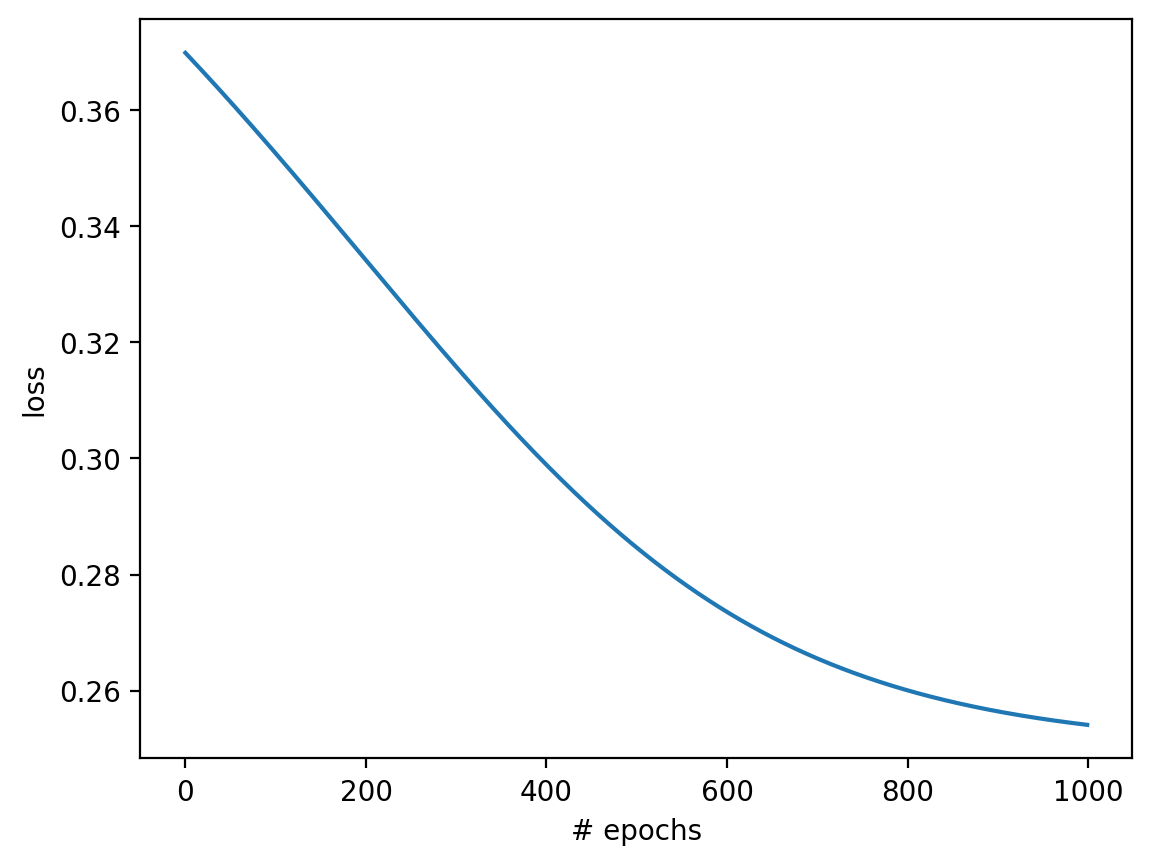

In [44]:
GD(X, y, weights, biases, epoch=1000, lr=0.01)

If implemented correctly, the loss should decrease and new weights and biases should make better than random predictions

`weights, biases = GD(X, y, weights, biases, epoch=1000, lr=0.01)`

<img src=https://i.imgur.com/VV0rROF.png width="600">

# 4. Putting it together

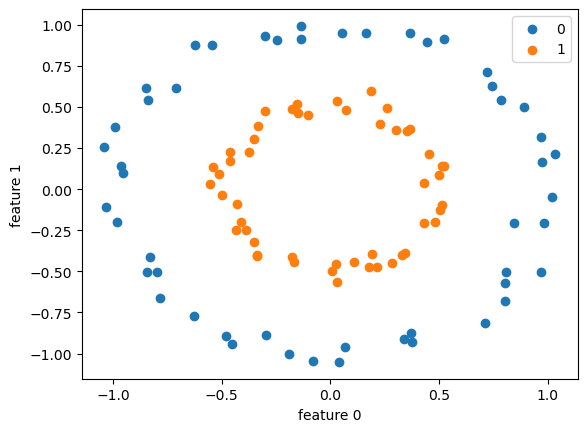

In [45]:
# Generate a dataset
X, y = make_circles(n_samples=100, noise=0.05, factor=0.5)
plt.figure(dpi=100)
plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0], label=0)
plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1], label=1)
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.legend()

In [46]:
y = y.reshape(-1, 1)
X.shape, y.shape

((100, 2), (100, 1))

In [47]:
# Initialize the network
weights, biases = initializer([2, 3, 1])

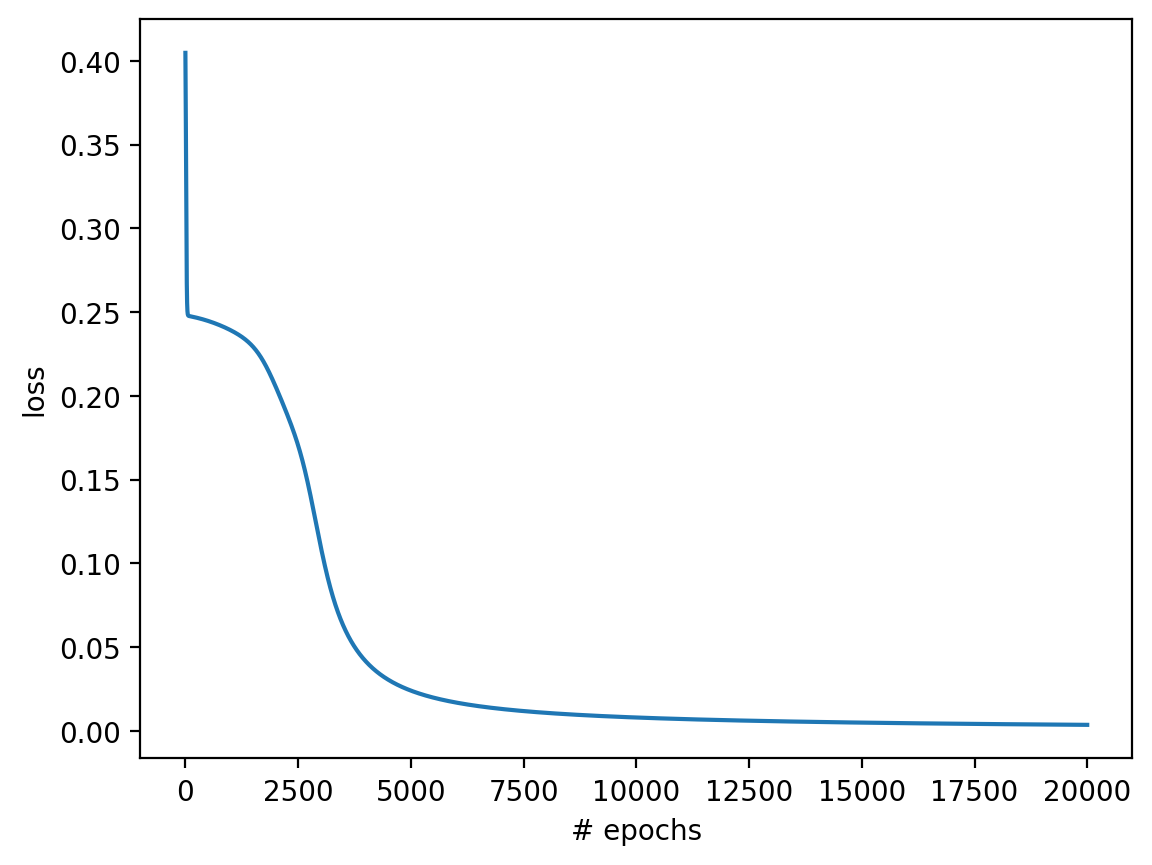

In [48]:
# Train the network
weights, biases = GD(X, y, weights, biases, epoch=20000, lr=0.3)

In [49]:
# Get predictions
y_pred = predict(X, weights, biases)

In [50]:
# Look at the first 10 preds vs. labels
np.concatenate((y_pred[0:10], y[0:10]), axis=1)

array([[0.03686277, 0.        ],
       [0.03567431, 0.        ],
       [0.05531445, 0.        ],
       [0.05186946, 0.        ],
       [0.99323615, 1.        ],
       [0.99019296, 1.        ],
       [0.96986845, 1.        ],
       [0.97206268, 1.        ],
       [0.04073281, 0.        ],
       [0.04258649, 0.        ]])

Text(0, 0.5, 'Output')

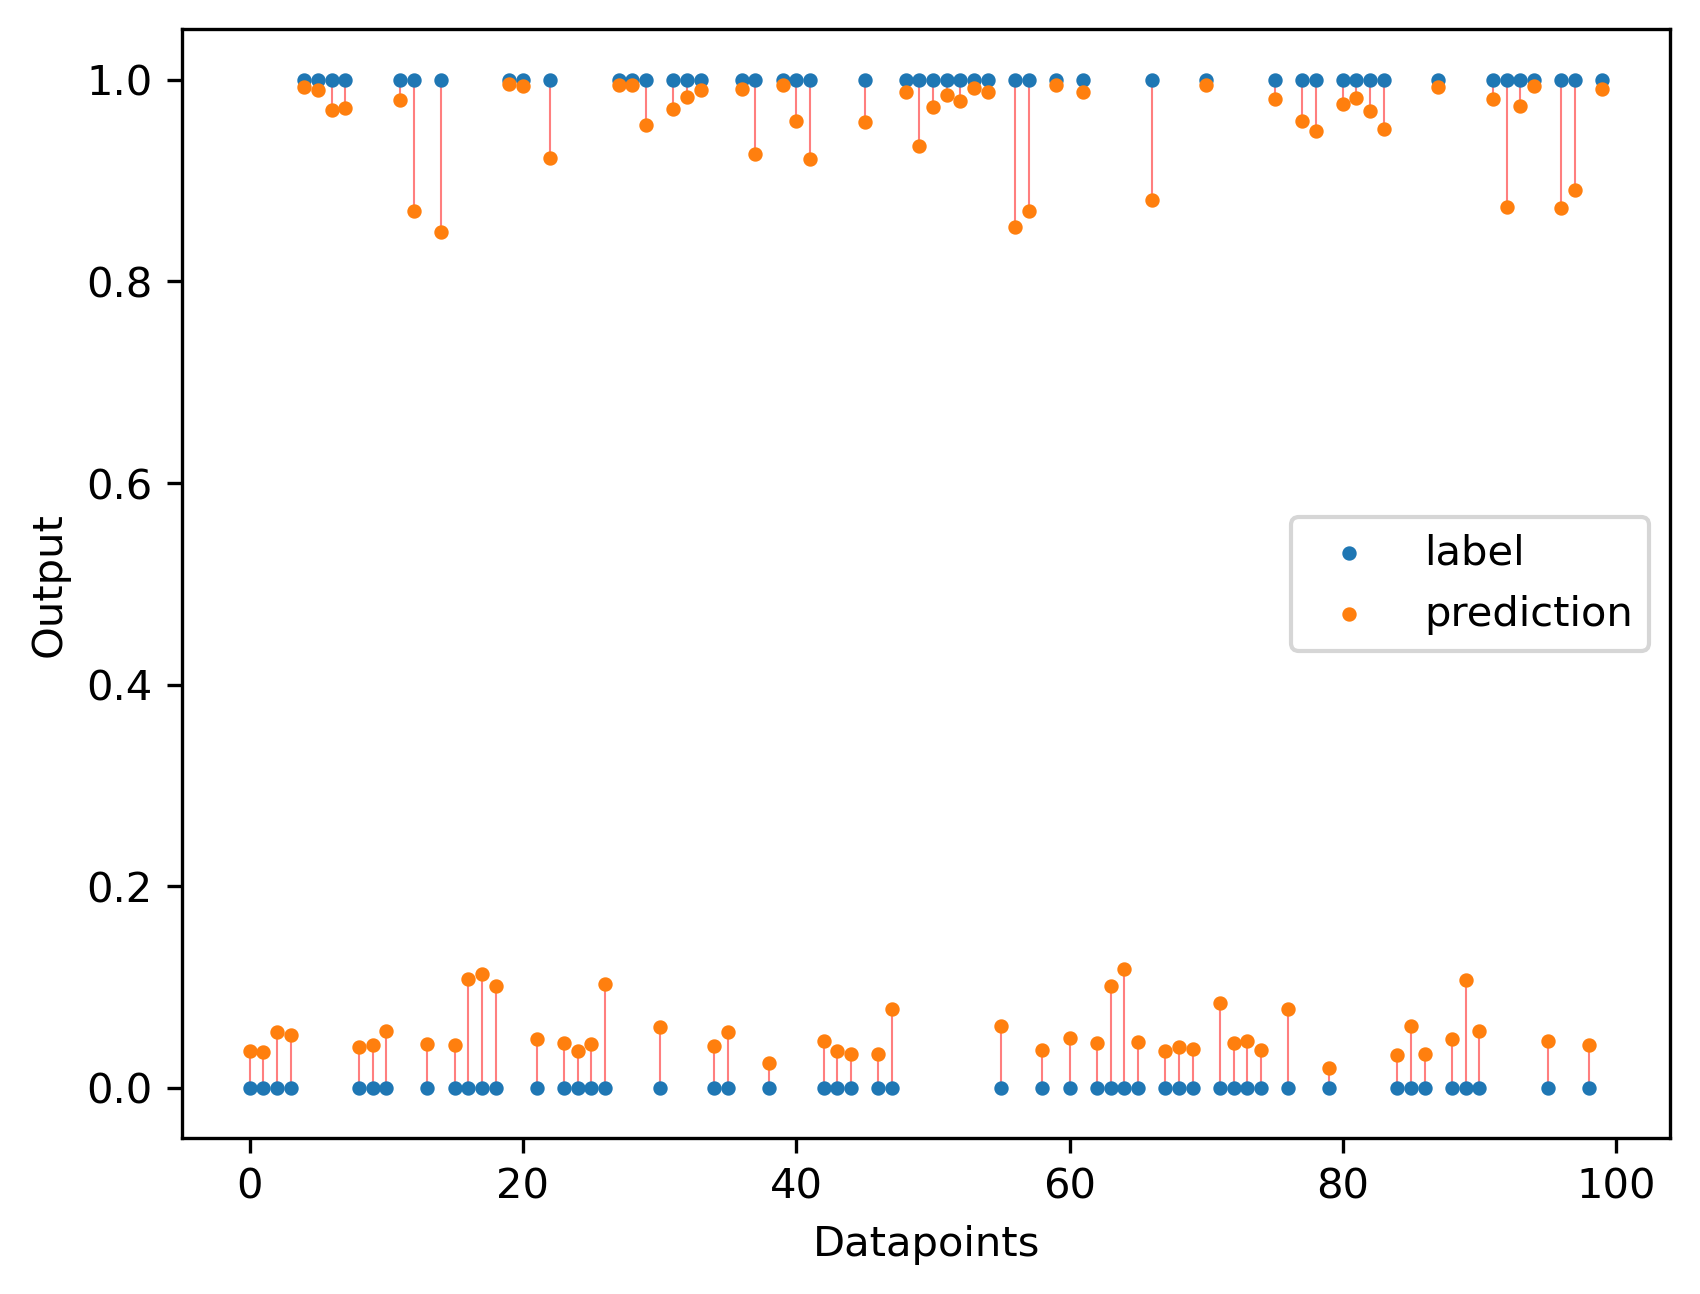

In [51]:
plt.figure(dpi=300)

for i in range(0, y.shape[0]):
    plt.plot([i, i], [y[i], y_pred[i]], color='red', zorder=-10, alpha=0.5, linewidth=0.5)

plt.scatter(np.arange(0, y.shape[0]), y, label='label', s=6)
plt.scatter(np.arange(0, y_pred.shape[0]), y_pred, label='prediction', s=6)

plt.legend()
plt.xlabel('Datapoints')
plt.ylabel('Output')

In [52]:
y_pred = (y_pred > 0.5)*1
accuracy(y_pred, y)

0.5

In [53]:
# Check accuracy on test set

# Generate the test set
X_te, y_te = make_circles(n_samples=100, noise=0.05, factor=0.5, random_state=1)
y_te = y_te.reshape(-1, 1)

# Get preds
test_preds = predict(X_te, weights, biases)

# Calculate acc
test_preds = (test_preds > 0.5)*1
accuracy(test_preds, y_te)

0.5